In [2]:
!pip install datasketch

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datasketch import MinHash, MinHashLSH
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import warnings

warnings.filterwarnings('ignore')

In [4]:
# load data from CSV
data = pd.read_csv('languages.csv')

In [5]:
data.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


In [7]:
data.describe()

,Text,language
count,22000,22000
unique,21859,22
top,haec commentatio automatice praeparata res ast...,Arabic
freq,48,1000


In [8]:
data.isnull().sum()

Text        0
language    0
dtype: int64

In [9]:
num_languages = data['language'].nunique()

print(f'Number of languages in the dataset is: {num_languages}')

Number of languages in the dataset is: 22


In [10]:
data["language"].value_counts()

Arabic        1000
Korean        1000
Estonian      1000
French        1000
Urdu          1000
Swedish       1000
Romanian      1000
English       1000
Latin         1000
Dutch         1000
Russian       1000
Hindi         1000
Thai          1000
Indonesian    1000
Japanese      1000
Pushto        1000
Persian       1000
Spanish       1000
Portugese     1000
Tamil         1000
Chinese       1000
Turkish       1000
Name: language, dtype: int64

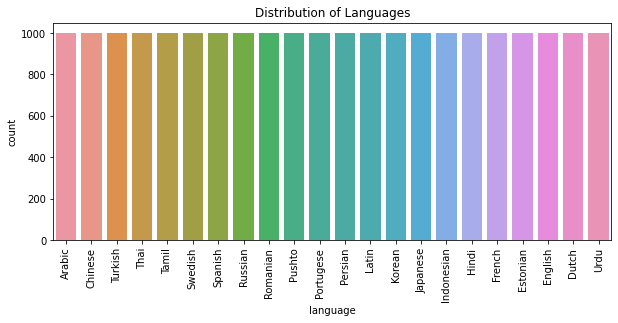

In [11]:
# Check for class imbalance

# Ensure the 'language' column is treated as a categorical variable, rather than string
data['language'] = data['language'].astype('category')

# Plot the distribution of languages
plt.figure(figsize=(10, 4))
sns.countplot(data=data, x='language', order=data['language'].value_counts().index)
plt.title('Distribution of Languages')
plt.xticks(rotation=90)
plt.show()

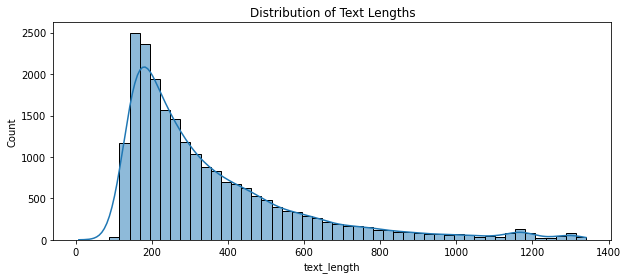

In [12]:
# Analyze the length of the text samples to understand their distribution
# This checks the length of each word in the language irrespective of the language name

data['text_length'] = data['Text'].apply(len)
plt.figure(figsize=(10, 4))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.show()

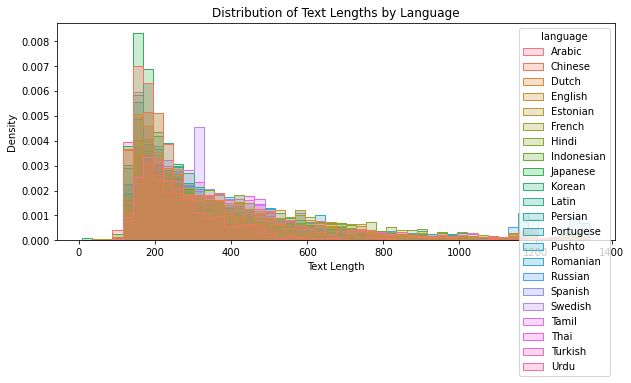

In [13]:
# Plot the distribution of text lengths for each language

plt.figure(figsize=(10, 4))
sns.histplot(data=data, x='text_length', hue='language', element='step', stat='density', common_norm=False, bins=50)
plt.title('Distribution of Text Lengths by Language')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.show()

In [14]:
# Count the Words in each Text

data['word_count'] = data['Text'].apply(lambda x: len(x.split()))

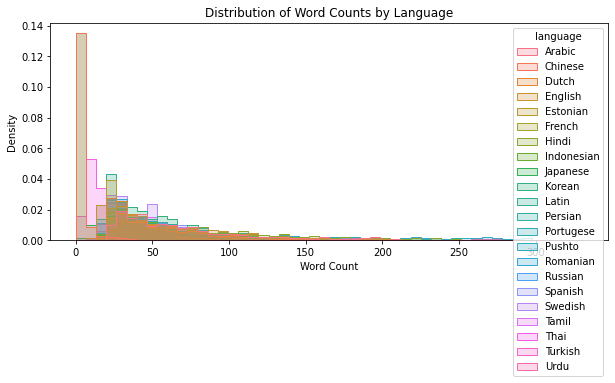

In [15]:
# Plot of the Distribution of Word Counts by Language

plt.figure(figsize=(10, 4))
sns.histplot(data=data, x='word_count', hue='language', element='step', stat='density', common_norm=False, bins=50)
plt.title('Distribution of Word Counts by Language')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.show()

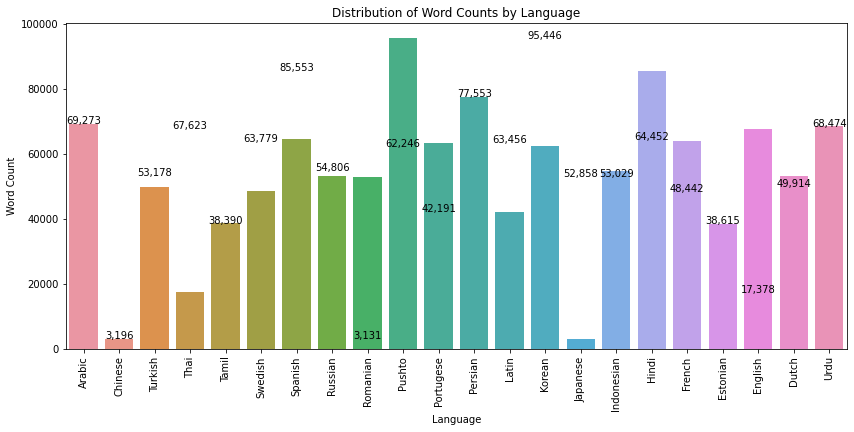

In [16]:
# Calculate the number of words for each language
word_counts = data.groupby('language')['word_count'].sum().reset_index()

# Plot the distribution of word counts for each language
plt.figure(figsize=(14, 6))
sns.barplot(data=word_counts, x='language', y='word_count', order=data['language'].value_counts().index)
plt.title('Distribution of Word Counts by Language')
plt.xlabel('Language')
plt.ylabel('Word Count')
plt.xticks(rotation=90)

# Display the count of words on top of each bar
for index, row in word_counts.iterrows():
    plt.text(index, row['word_count'], f"{row['word_count']:,}", color='black', ha="center")

plt.show()

In [17]:
# Top Words by Language
# Identify the most frequent words in each language

# Limit vocabulary size and use sparse matrices
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data['Text'])

# No need to convert to dense array, keep it sparse
#word_counts = pd.DataFrame.sparse.from_spmatrix(X, columns=vectorizer.get_feature_names_out())
word_counts = pd.DataFrame.sparse.from_spmatrix(X, columns=vectorizer.get_feature_names())



# Add language column
word_counts['language'] = data['language']

# Group by language and sum counts
top_words = word_counts.groupby('language').sum().T

# Print top words for each language
for lang in top_words.columns:
    print(f'Top words in {lang}:')
    print(top_words[lang].sort_values(ascending=False).head(10))

Top words in Arabic:
في      2711
من      1913
على      975
إلى      673
أن       519
التي     381
عن       372
عام      366
أو       332
ما       306
Name: Arabic, dtype: Sparse[int64, 0]
Top words in Chinese:
年月日       165
月日        146
年月         81
mai        32
live       30
賽德克        27
kuraki     26
tour       18
best       16
music      16
Name: Chinese, dtype: Sparse[int64, 0]
Top words in Dutch:
van     2047
het     1654
een     1379
en      1351
op       624
voor     575
met      518
door     500
werd     489
zijn     466
Name: Dutch, dtype: Sparse[int64, 0]
Top words in English:
new       204
school    178
state     114
time      111
page      110
film      101
team      101
years      89
high       88
world      88
Name: English, dtype: Sparse[int64, 0]
Top words in Estonian:
ja        1320
ta         371
oli        324
ning       269
aastal     262
ka         258
mis        225
kui        218
või        182
et         166
Name: Estonian, dtype: Sparse[int64, 0]
Top words

In [18]:
# Pairwise Language Similarity
# Analyze the similarity between different languages based on text data


# # Create TF-IDF matrix
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# # Reduce dimensionality using TruncatedSVD
# svd = TruncatedSVD(n_components=100)
# tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# # Calculate cosine similarity
# similarities = cosine_similarity(tfidf_matrix_reduced, tfidf_matrix_reduced)

# # Create similarity DataFrame
# similarity_df = pd.DataFrame(similarities, index=data['language'], columns=data['language'])

# # Plot pairwise language similarity
# plt.figure(figsize=(12, 6))
# sns.heatmap(similarity_df, cmap='coolwarm')
# plt.title('Pairwise Language Similarity (TruncatedSVD)')
# plt.show()
# End



# # Create TF-IDF vectorizer with stop words removed
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# # Initialize MinHashLSH
# num_perm = 128  # Number of permutations
# lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)

# # Create MinHash signatures and index
# for i, text in enumerate(data['Text']):
#     min_hash = MinHash(num_perm=num_perm)
#     for word in text.split():
#         min_hash.update(word.encode('utf-8'))
#     lsh.insert(i, min_hash)

# # Compute similar documents
# similar_docs = {}
# for i, text in enumerate(data['Text']):
#     min_hash_query = MinHash(num_perm=num_perm)
#     for word in text.split():
#         min_hash_query.update(word.encode('utf-8'))
#     results = lsh.query(min_hash_query)
#     similar_docs[i] = results

# # Print similar documents
# for i, results in similar_docs.items():
#     print(f"Similar documents to document {i}: {results}")
# End



# # Create TF-IDF vectorizer with stop words removed
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# # Initialize MinHashLSH
# num_perm = 128  # Number of permutations
# lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)

# # Create MinHash signatures and index
# for i, text in enumerate(data['Text']):
#     min_hash = MinHash(num_perm=num_perm)
#     for word in text.split():
#         min_hash.update(word.encode('utf-8'))
#     lsh.insert(i, min_hash)

# # Compute similar documents
# similar_docs = {}
# for i, text in enumerate(data['Text']):
#     min_hash_query = MinHash(num_perm=num_perm)
#     for word in text.split():
#         min_hash_query.update(word.encode('utf-8'))
#     results = lsh.query(min_hash_query)
#     similar_docs[i] = results

# # Print similar documents with language names
# for i, results in similar_docs.items():
#     doc_language = data.loc[i, 'language']
#     print(f"Similar documents to document {i} ({doc_language}):")
#     for similar_doc_index in results:
#         similar_doc_language = data.loc[similar_doc_index, 'language']
#         print(f"  - Document {similar_doc_index}: {similar_doc_language}")

# End



# # Create TF-IDF vectorizer with stop words removed
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# # Initialize MinHashLSH
# num_perm = 128  # Number of permutations
# lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)

# # Create MinHash signatures and index
# for i, text in enumerate(data['Text']):
#     min_hash = MinHash(num_perm=num_perm)
#     for word in text.split():
#         min_hash.update(word.encode('utf-8'))
#     lsh.insert(i, min_hash)

# # Compute similar documents
# similar_docs = {}
# for i, text in enumerate(data['Text']):
#     min_hash_query = MinHash(num_perm=num_perm)
#     for word in text.split():
#         min_hash_query.update(word.encode('utf-8'))
#     results = lsh.query(min_hash_query)
#     similar_docs[i] = results

# # Aggregate similar languages
# similar_languages = {}
# for i, results in similar_docs.items():
#     doc_language = data.loc[i, 'language']
#     if doc_language not in similar_languages:
#         similar_languages[doc_language] = set()
#     for similar_doc_index in results:
#         similar_doc_language = data.loc[similar_doc_index, 'language']
#         if similar_doc_language != doc_language:
#             similar_languages[doc_language].add(similar_doc_language)

# # Print similar languages
# for language, similar_langs in similar_languages.items():
#     print(f"Languages similar to {language}:")
#     for similar_lang in similar_langs:
#         print(f"  - {similar_lang}")
# End



# Create TF-IDF vectorizer with stop words removed
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# Initialize MinHashLSH
num_perm = 128  # Number of permutations
lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)

# Create MinHash signatures and index
for i, text in enumerate(data['Text']):
    min_hash = MinHash(num_perm=num_perm)
    for word in text.split():
        min_hash.update(word.encode('utf-8'))
    lsh.insert(i, min_hash)

# Compute similar documents
similar_docs = defaultdict(list)
for i, text in enumerate(data['Text']):
    min_hash_query = MinHash(num_perm=num_perm)
    for word in text.split():
        min_hash_query.update(word.encode('utf-8'))
    results = lsh.query(min_hash_query)
    similar_docs[i] = results

# Aggregate similar languages
similar_languages = defaultdict(lambda: defaultdict(int))
representative_words = defaultdict(lambda: defaultdict(set))

for i, results in similar_docs.items():
    doc_language = data.loc[i, 'language']
    for similar_doc_index in results:
        similar_doc_language = data.loc[similar_doc_index, 'language']
        if similar_doc_language != doc_language:
            similar_languages[doc_language][similar_doc_language] += 1
            representative_words[doc_language][similar_doc_language].update(
                data.loc[similar_doc_index, 'Text'].split()[:5]  # Get first 5 words as representatives
            )

# Print similar languages with details
for language, sim_langs in similar_languages.items():
    print(f"Languages similar to {language}:")
    for similar_lang, count in sim_langs.items():
        words = ', '.join(representative_words[language][similar_lang])
        print(f"  - {similar_lang} (similar documents: {count}, representative words: {words})")

Languages similar to Portugese:
  - Spanish (similar documents: 7, representative words: epítetos, encontrar, uno, puede, más)
Languages similar to Dutch:
  - Estonian (similar documents: 2, representative words: marcus, ekr-, pkr, apicius, gavius)
  - French (similar documents: 1, representative words: d, clubs, certains, pro, de)
Languages similar to Romanian:
  - Spanish (similar documents: 2, representative words: o, ejército, ac, victoria, del, n, la, f, zuloaga)
Languages similar to Spanish:
  - Romanian (similar documents: 2, representative words: tshimbulu, în, marie-thérèse, n, suzanne, oraș, jacqueline, auriol-douet, un, este)
  - Portugese (similar documents: 7, representative words: o, tradicionalmente, as, filme, a, no, garnizé, enfrentou, os, campo, daley, guerra, já, alexandre, protocolo, original, como, do, descobriu, foram, dom, consequência, nick, poty, não, latinos, em, diaz, mulheres, de, roteiro)
Languages similar to French:
  - Dutch (similar documents: 1, represe

In [19]:
# Splitting the data into training, validation and test sets

x = np.array(data["Text"])
y = np.array(data["language"])

# First split to create training and temporary sets (temp contains validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.33, random_state=42)

# Second split to create validation and test sets from the temporary set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the text data
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_val_cv = cv.transform(X_val)
X_test_cv = cv.transform(X_test)

In [20]:
# Training the model

model = MultinomialNB()
model.fit(X_train_cv, y_train)

MultinomialNB()

In [21]:
# Validate the model
y_val_pred = model.predict(X_val_cv)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 96.06%


In [22]:
# Testing the model's performance

# Evaluate the model on the test set
y_test_pred = model.predict(X_test_cv)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 95.43%


In [23]:
# Using the model

# User input for prediction
user_input = input("Enter a text: ").strip()
if user_input:
    data = cv.transform([user_input]).toarray()
    output = model.predict(data)
    print(f"Predicted Language: {output[0]}")
else:
    print("No input provided. Please enter some text")

Enter a text: okada
Predicted Language: Chinese


In [26]:
# Define the models

models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

In [31]:
# Train, validate, and test with each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    try:
        # Train the model
        model.fit(X_train_cv, y_train)

        # Validate the model
        y_val_pred = model.predict(X_val_cv)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        print(f"{name} Validation Accuracy: {val_accuracy * 100:.2f}%")

        # Evaluate the model on the test set
        y_test_pred = model.predict(X_test_cv)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print(f"{name} Test Accuracy: {test_accuracy * 100:.2f}% \n")

        results[name] = test_accuracy
    except Exception as e:
        print(f"Error training {name}: {e}")

# Display the results
print("\nModel Comparison:")
for name, accuracy in results.items():
    print(f"{name}: Test Accuracy = {accuracy * 100:.2f}% \n")

# Predict language for user input using the best model
try:
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    print(f"Using Best Model: {best_model_name}")

    user_input = input("Enter a text: ").strip()
    if user_input:
        # Vectorize user input
        data = cv.transform([user_input]).toarray()

        # Predict the language
        output = best_model.predict(data)
        print(f"Predicted Language by {best_model_name}: {output[0]}")
    else:
        print("No input provided. Please enter some texts.")
except NotFittedError:
    print(f"Error: The model '{best_model_name}' is not fitted. Ensure it is properly trained.")
except Exception as e:
    print(f"Unexpected error: {e}")


Training Multinomial Naive Bayes...
Multinomial Naive Bayes Validation Accuracy: 96.06%
Multinomial Naive Bayes Test Accuracy: 95.43% 

Training Logistic Regression...
Logistic Regression Validation Accuracy: 94.33%
Logistic Regression Test Accuracy: 94.16% 

Training Support Vector Machine...
Support Vector Machine Validation Accuracy: 95.51%
Support Vector Machine Test Accuracy: 95.54% 

Training Random Forest...
Random Forest Validation Accuracy: 91.90%
Random Forest Test Accuracy: 92.07% 

Training Neural Network...
Neural Network Validation Accuracy: 96.61%
Neural Network Test Accuracy: 96.80% 


Model Comparison:
Multinomial Naive Bayes: Test Accuracy = 95.43% 

Logistic Regression: Test Accuracy = 94.16% 

Support Vector Machine: Test Accuracy = 95.54% 

Random Forest: Test Accuracy = 92.07% 

Neural Network: Test Accuracy = 96.80% 

Using Best Model: Neural Network
Enter a text: oga adimma
Predicted Language by Neural Network: Japanese
